In [1]:
import torch
import random

random.seed(0)
torch.manual_seed(0)
print(torch.cuda.is_available())

True


In [2]:
import numpy as np

import sys
import os
sys.path.append(os.path.join(os.environ['BART_TOOLBOX_PATH'], 'python'))
from bart import bart

num_readout_points = 320
oversampling_ratio = 2
num_spoke = 500

points_per_phase = num_readout_points * oversampling_ratio

gatraj = bart(1, f"traj -r -x{num_readout_points} -y{num_spoke} -G -o{oversampling_ratio}")

gatraj_raw = gatraj.copy()

print(gatraj.dtype)

print(gatraj.shape)

import torch
from einops import rearrange

gatraj = torch.tensor(gatraj)
gatraj = rearrange(gatraj, 'pos readout phase -> phase readout pos')
gatraj = gatraj[:,:,:2]

print(gatraj.shape)



complex64
(3, 640, 500)
torch.Size([500, 640, 2])


In [3]:
# plt trajactory

import matplotlib.pyplot as plt

plt.figure()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [4]:
# Dataset
trainlistpath = "/home/liyy/data1/moco/datasets/.Fastmri_pics/trainlist.txt"
vallistpath = "/home/liyy/data1/moco/datasets/.Fastmri_pics/vallist.txt"
testlistpath = "/home/liyy/data1/moco/datasets/.Fastmri_pics/testlist.txt"

with open(trainlistpath, 'r') as f:
    trainlist = f.readlines()
    trainlist = [(line.split()[0], int(line.split()[1])) for line in trainlist]

with open(vallistpath, 'r') as f:
    vallist = f.readlines()
    vallist = [(line.split()[0], int(line.split()[1])) for line in vallist]

with open(testlistpath, 'r') as f:
    testlist = f.readlines()
    testlist = [(line.split()[0], int(line.split()[1])) for line in testlist]

import torch
from torchvision import transforms
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

from models import mynn as mynn
from models.mynn import functional as myf

from random import shuffle

from einops import rearrange, repeat

import utils.bindings_nufft_pytorch.nufftbindings.kbnufft as nufft

# ismrmrd_header rss csm kspace
class MyDataset(Dataset):
    def __init__(self, filelist, num_subset = None, transform=None, lazy_memory=True, output_keys=["kspace", "after_transform"], output_type = dict):
        super(MyDataset, self).__init__()
        self.filelist = filelist
        self.num_subset = num_subset
        self.transform = transform
        self.lazy_cache = lazy_memory
        self.output_keys = output_keys
        self.output_type = output_type
        

        if self.num_subset is not None:
            self.filelist = self.filelist[:self.num_subset]

        self._cache = {}
        self._keys = ["kspace", "csm", "rss"]

        if not lazy_memory:
            try:
                for file in filelist:
                    path, index = file
                    if path not in self._cache:
                        self.load(path)
            except MemoryError as e: # The total size of the dataset is about 400GB
                print("Memory Error in preloading the dataset.", e)
                print("Lazy memory is recommended. Automatically switch to lazy memory.")
                self.release(ratio=0.75)
                self.lazy_cache = True

    def load(self, path):
        with np.load(path) as data:
            self._cache[path] = {key: torch.tensor(data[key]) for key in self._keys}
            self._cache[path].update(self.transform(self._cache[path]))

    def release(self, ratio = 0.5):
        assert 0 < ratio <= 1 , "The ratio must be a float between 0 and 1."

        keys_to_delete = shuffle(list(self._cache.keys()))[:int(len(self._cache) * ratio)]
        for key in keys_to_delete:
            del self._cache[key]


    def __len__(self):
        return len(self.filelist)
    
    def __getitem__(self, idx):
        file = self.filelist[idx]
        path, index = file

        if path not in self._cache:
            try:
                self.load(path)
            except MemoryError as e:
                self.release()
                self.load(path) # try again

        if self.output_type == dict:
            return {key: self._cache[path][key][index] for key in self.output_keys}
        elif self.output_type == list:
            return [self._cache[path][key][index] for key in self.output_keys]
        
from torchkbnufft import KbNufft, KbNufftAdjoint, calc_tensor_spmatrix, calc_density_compensation_function
from einops import rearrange
from torchvision import transforms


class Transform(nn.Module):
    def __init__(self, image_size, num_spokes_full, num_spokes_partial, motion_params=[5, 0.01, 0.01, 0], motion_prob=0.5, num_chance_motion = 1):
        super(Transform, self).__init__()
        self.image_size = image_size
        self.num_spokes_full = num_spokes_full
        self.num_spokes_partial = num_spokes_partial
        self.motion_params = motion_params
        self.motion_prob = motion_prob
        self.num_chance_motion = num_chance_motion

        self._nufft_obj = KbNufft(im_size=image_size, device='cuda')
        self._inufft_obj = KbNufftAdjoint(im_size=image_size, device='cuda')

        # self._nufft_binding_obj = nufft.Nufft()

        self.affine = transforms.RandomAffine(degrees=motion_params[0], 
                                              translate=(motion_params[1], motion_params[1]), 
                                              scale=(1-motion_params[2], 1+motion_params[2]), 
                                              shear=motion_params[3],
                                              fill = 0
                                              )


        self.traj_raw = gatraj.clone().to(torch.float32) # phase readout pos
        self.traj_raw = torch.view_as_complex(self.traj_raw) # phase readout
        # use complex number to represent the trajectory position
        # for example, traj[0,0] = 0.1 + 0.2j means the first point position in cartesian coordinate is (0.1, 0.2)
        # in other words, traj[0,0] = 0.1 + 0.2j means the first point position in polar coordinate is ( abs(0.1 + 0.2j), angle(0.1 + 0.2j) )

        self.traj_full = self.traj_raw[:num_spokes_full]
        self.traj_partial = self.traj_raw[:num_spokes_partial]

        # self._nufft_binding_obj.set_dims(num_spoke * num_readout_points * oversampling_ratio, image_size, torch.device('cuda'))
        # self.precompute()

    def precompute(self):
        traj = self.traj_full
        traj = traj.to('cuda')
        traj_shape = traj.shape
        traj = traj / 160 * torch.pi # bart normalization to torchkbnufft normalization
        traj = torch.view_as_real(traj)
        traj = rearrange(traj, '... phase readout pos -> ... (phase readout) pos')
        self._nufft_binding_obj.precompute(traj)

    def motion(self, image : torch.Tensor) -> torch.Tensor:
        image_device = image.device
        image = image.to('cuda')
        image = myf.complex_to_real(image)
        image = self.affine(image)
        image = myf.real_to_complex(image)
        return image.to(image_device)


    def nufft(self, image, ktraj):
        obj =  nufft.Nufft()
        obj.set_dims(ktraj.shape[-1] * ktraj.shape[-2], self.image_size, torch.device('cuda'))


        device = image.device
        image = image.to(torch.device("cuda"))
        ktraj = ktraj.to(torch.device("cuda"))

        traj_shape = tuple(ktraj.shape)
        image_shape = tuple(image.shape)

        ktraj = ktraj / 160 * torch.pi # bart normalization to torchkbnufft normalization
        ktraj = torch.view_as_real(ktraj)
        ktraj = rearrange(ktraj, '... phase readout pos -> ... (phase readout) pos')

        obj.precompute(ktraj)

        image = rearrange(image, ' ... h w -> (...) h w')

        kdata = obj.forward(image, ktraj)

        kdata = rearrange(kdata, '(s c) (phase readout) -> s c phase readout', s = image_shape[0], c= image_shape[1], phase = traj_shape[-2], readout = traj_shape[-1])

        # res = rearrange(res, '... (readout phase) ->... phase readout', phase=traj_shape[0], readout=traj_shape[1])

        kdata = kdata.to(device)
        return kdata
    

    def dcomp(self, kdata, ktraj):
        device = kdata.device
        kdata = kdata.to(torch.device("cuda"))
        ktraj = ktraj.detach().to(torch.device("cuda"))

        kdata_shape = kdata.shape

        ktraj = ktraj / 160 * torch.pi # bart normalization to torchkbnufft normalization
        ktraj = torch.view_as_real(ktraj)
        ktraj = rearrange(ktraj, 'phase readout pos -> pos (readout phase)')
        kdata = rearrange(kdata, '... phase readout -> ... (readout phase)')

        dcomp = calc_density_compensation_function(ktraj=ktraj, im_size=self.image_size)

        kdata = kdata * dcomp
        kdata = rearrange(kdata, '... (readout phase) -> ... phase readout', phase = kdata_shape[-2], readout = kdata_shape[-1])
        kdata = kdata.to(device)
        return kdata
    
    def inufft(self, kdata, ktraj):
        obj =  nufft.Nufft()
        obj.set_dims(ktraj.shape[-1] * ktraj.shape[-2], self.image_size, torch.device('cuda'))

        kdata = self.dcomp(kdata, ktraj)

        device = kdata.device
        kdata = kdata.to(torch.device("cuda"))
        ktraj = ktraj.to(torch.device("cuda"))

        kdata_shape = tuple(kdata.shape)

        ktraj = ktraj / 160 * torch.pi # bart normalization to torchkbnufft normalization
        ktraj = torch.view_as_real(ktraj)
        ktraj = rearrange(ktraj, '... phase readout pos -> ... (phase readout) pos')

        obj.precompute(ktraj)

        kdata = rearrange(kdata, ' ... phase readout -> (...) (phase readout)')

        image = obj.adjoint(kdata, ktraj)

        image = rearrange(image, '(s c) h w -> s c h w', s = kdata_shape[0], c= kdata_shape[1])

        image = image.to(device)
        return image

    
    def mean_std_norm_complex(self, data):
        real = data.real
        imag = data.imag
        real = (real - real.mean()) / real.std()
        imag = (imag - imag.mean()) / imag.std()
        return real + 1j * imag


    def forward(self, sample):
        kspace = sample["kspace"].to(torch.complex64)
        image = myf.ktoi(kspace)
        image = self.mean_std_norm_complex(image)

        kspace_full = self.nufft(image, self.traj_full) # slice channel phase readout

        for _ in range(self.num_chance_motion):
            image_motion = self.motion(image)
            
            # # show 
            # import matplotlib.pyplot as plt
            # plt.figure()
            # plt.imshow(image_motion[0][0].abs().cpu().numpy(), cmap = 'gray')
            # plt.axis('off')
            # plt.show()


            # 运动图像以self.motion_prob的概率拼接到静止的kspace上
            phase_index = torch.randperm(self.num_spokes_full)
            phase_index_motion = phase_index[:int(self.num_spokes_full * self.motion_prob)]
            pos_seq_motion = self.traj_full[phase_index_motion]

            kspace_motion = kspace_full.clone()
            kspace_motion[:, :, phase_index_motion, :] = self.nufft(image_motion, pos_seq_motion)
        
        pos_seq_full = repeat(self.traj_full, 'phase readout -> slice phase readout', slice=image.shape[0])
        # pos_seq_motion = repeat(pos_seq_motion, 'phase readout -> slice phase readout', slice=image.shape[0])

        return {"kspace_before": kspace_full, "kspace_after": kspace_motion, "pos_seq_before": pos_seq_full, "pos_seq_after": pos_seq_full, "image": image}
    

transform = Transform((320, 320), num_spoke, num_spoke, motion_params=[15,0.02,0.02 ,5], motion_prob=0.5, num_chance_motion=20)

train_dataset = MyDataset(trainlist, transform=transform, output_keys=["kspace_before", "kspace_after", "pos_seq_before", "pos_seq_after", "image"], output_type=dict, num_subset=1)
val_dataset = MyDataset(vallist, transform=transform, output_keys=["kspace_before", "kspace_after", "pos_seq_before", "pos_seq_after", "image"], output_type=dict, num_subset=1)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

print(len(train_dataset))
print(len(val_dataset))
    

1
1


/tmp/ipykernel_3288351/471173029.py:123: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/native/Copy.cpp:308.)
  self.traj_raw = gatraj.clone().to(torch.float32) # phase readout pos


image:  1  16  320  320  kspace_before:  1  16  500  640  kspace_after:  1  16  500  640  pos_seq_before:  500  640  pos_seq_after:  500  640
image_recon_before:  1  16  320  320  image_recon_after:  1  16  320  320
mse 0.19205814599990845
ssim 0.9226084


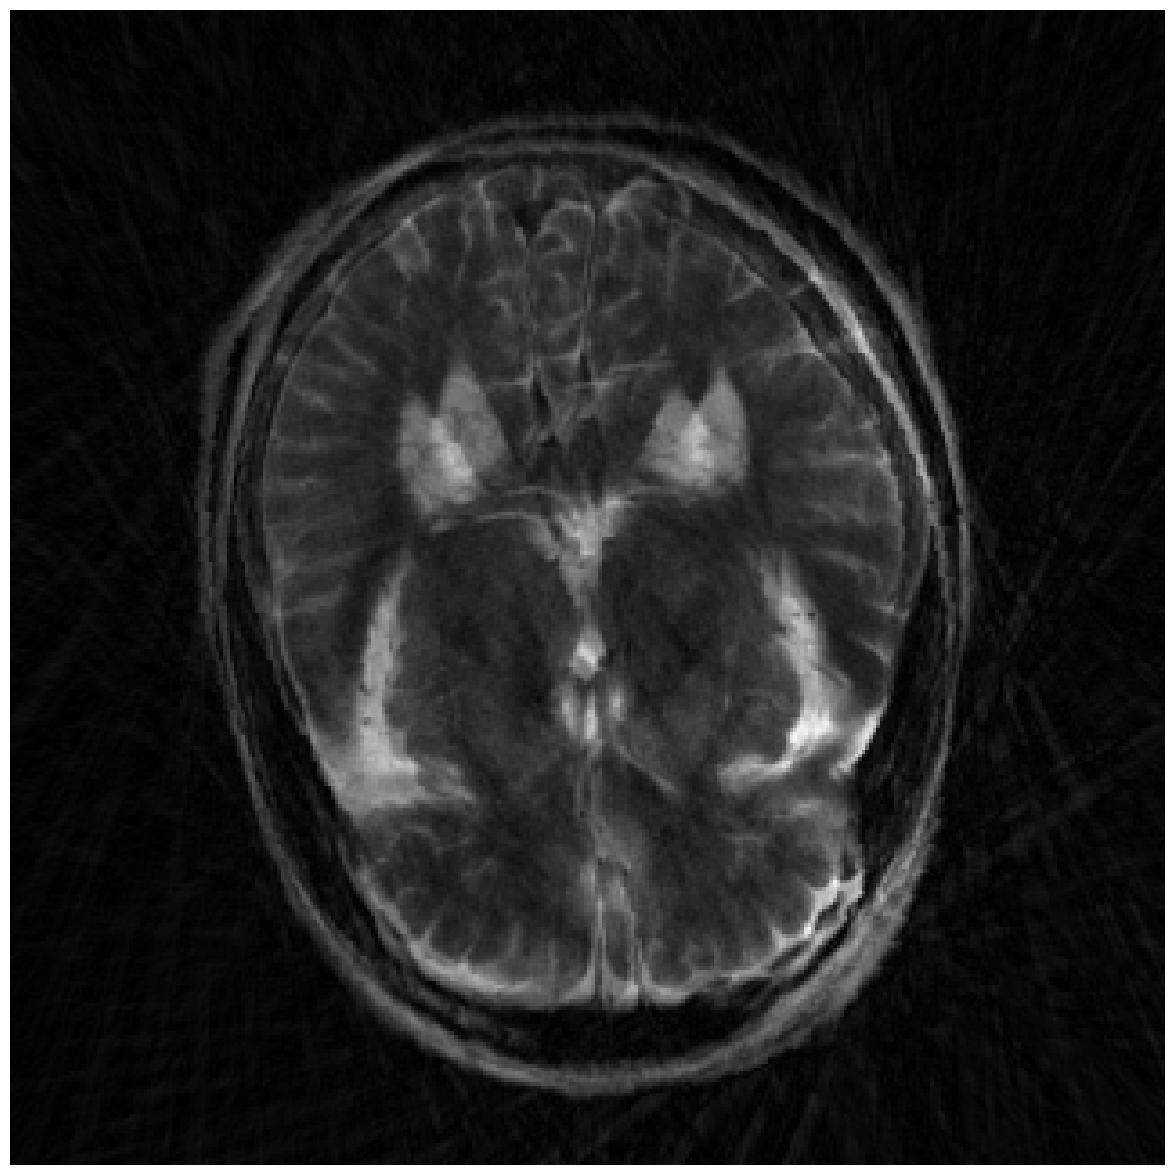

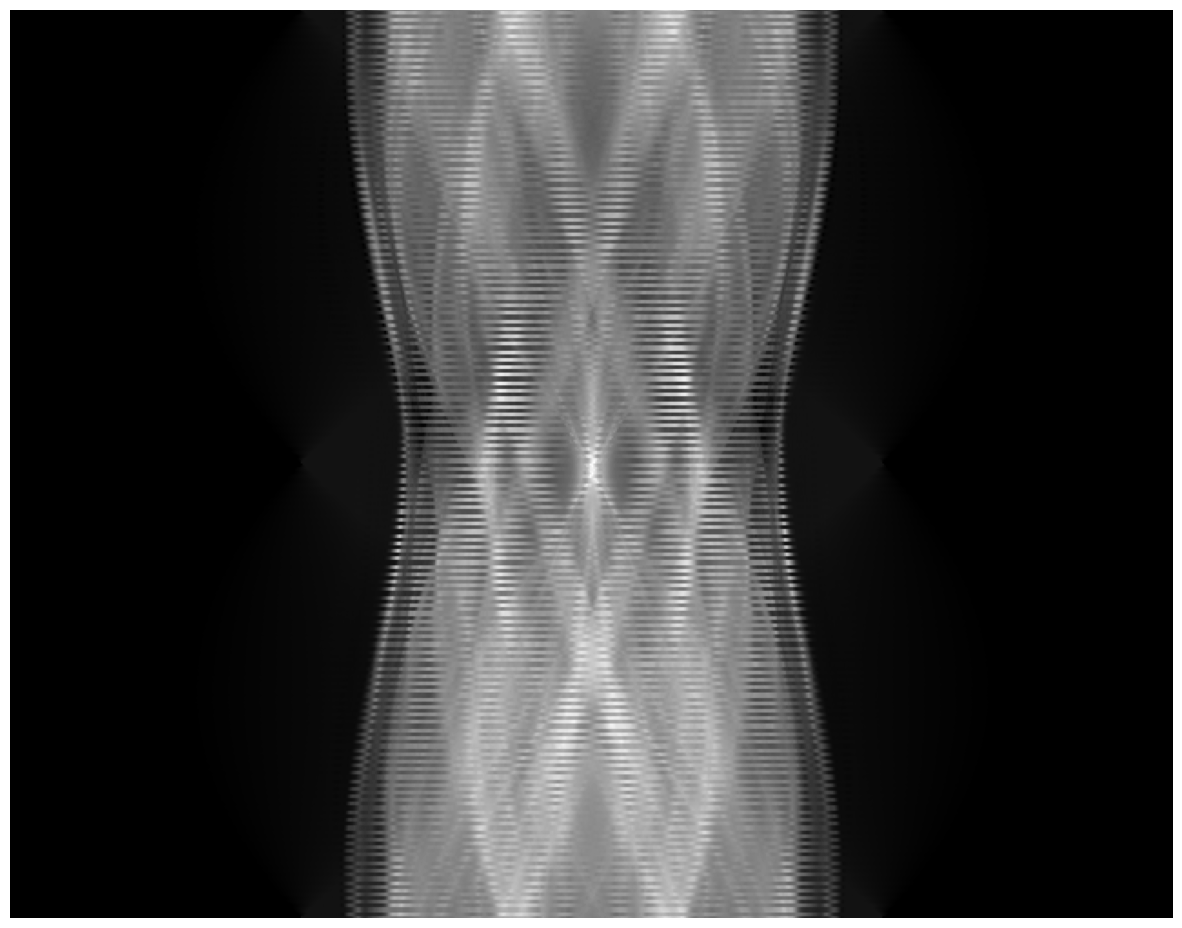

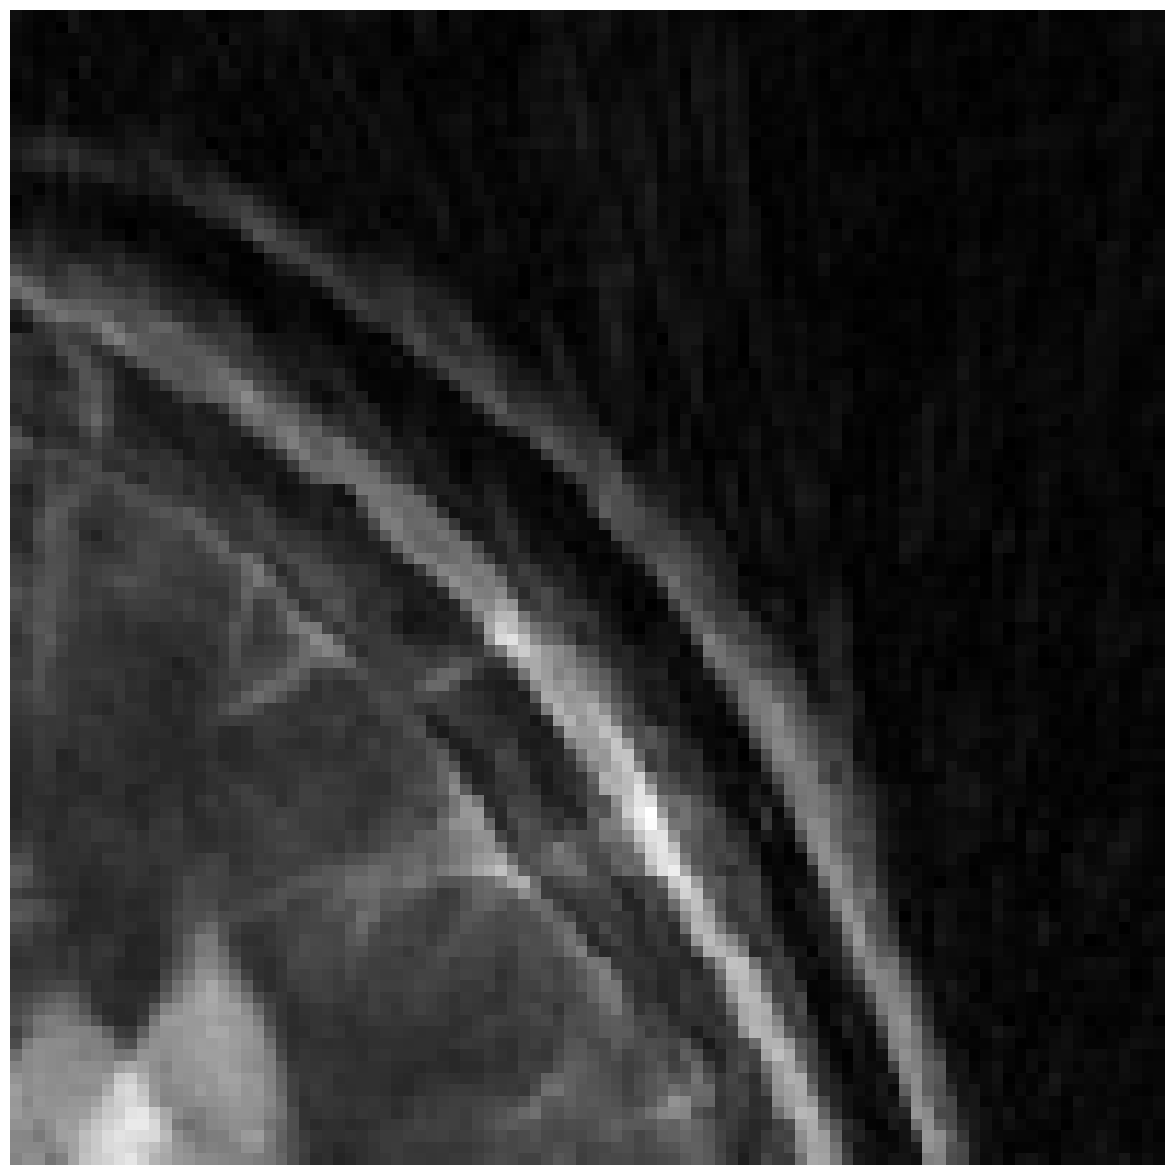

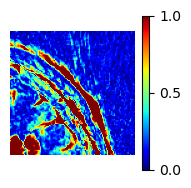

In [ ]:
# show train dataset sample 0 - 5

import matplotlib.pyplot as plt
from torch.nn import functional as F
from skimage.metrics import structural_similarity
from models.mynn import functional as myf

import random

random.seed(0)

def mean_std_norm_complex(data):
    data_real = data.real
    data_imag = data.imag
    data_real = (data_real - data_real.mean()) / data_real.std()
    data_imag = (data_imag - data_imag.mean()) / data_imag.std()
    return data_real + 1j * data_imag

def mean_std_norm_real(data):
    data = (data - data.mean()) / data.std()
    return data

def mse(image1, image2):
    image1 = mean_std_norm_complex(image1)
    image1 = torch.view_as_real(image1)
    image2 = mean_std_norm_complex(image2)
    image2 = torch.view_as_real(image2)
    return F.mse_loss(image1, image2)

def ssim(image1, image2):
    image1 = mean_std_norm_complex(image1)
    image1 = myf.complex_to_real(image1).numpy()
    image2 = mean_std_norm_complex(image2)
    image2 = myf.complex_to_real(image2).numpy()
    return structural_similarity(image1[0], image2[0], channel_axis=0, data_range=image1.max() - image1.min())

for i in random.sample(range(0, len(train_dataset)), min(1, len(train_dataset))):
    sample = train_dataset[i]
    image = sample["image"].unsqueeze(0)
    kspace_before = sample["kspace_before"].unsqueeze(0)
    kspace_after = sample["kspace_after"].unsqueeze(0)
    pos_seq_before = sample["pos_seq_before"]
    pos_seq_after = sample["pos_seq_after"]

    # print(pos_seq_full)

    # print shapes
    print('image:', *image.shape, 'kspace_before:', *kspace_before.shape, 'kspace_after:', *kspace_after.shape, 'pos_seq_before:', *pos_seq_before.shape, 'pos_seq_after:', *pos_seq_after.shape, sep='  ')

    image_recon_before = transform.inufft(kspace_before, pos_seq_before)
    image_recon_after = transform.inufft(kspace_after, pos_seq_after)

    print('image_recon_before:', *image_recon_before.shape, 'image_recon_after:', *image_recon_after.shape, sep='  ')

    print('mse', mse(image_recon_before, image_recon_after).item())

    print('ssim', ssim(image_recon_before, image_recon_after))

    # plt.figure(figsize=(45, 15))
    # plt.subplot(1, 3, 1)
    # plt.imshow(torch.abs(image[0][0]), cmap="gray")
    # plt.title("image")
    # plt.axis('off')
    # plt.subplot(1, 3, 2)
    # plt.imshow(torch.abs(image_recon_before[0][0]), cmap="gray")
    # plt.title("image_recon_full")
    # plt.axis('off')
    # plt.subplot(1, 3, 3)
    # plt.imshow(torch.abs(image_recon_after[0][0]), cmap="gray")
    # plt.title("image_recon_motion")
    # plt.axis('off')
    # plt.show()
    
    plt.figure(figsize=(15, 15))
    plt.imshow(torch.abs(image_recon_after[0][0]), cmap="gray")
    plt.axis('off')
    plt.show()

    projection = myf.ktoi(kspace_before, dim=-1)

    projection_showable = torch.abs(projection[0][0])

    # gatraj_complex = torch.view_as_complex(gatraj.to(torch.float32))
    # gatraj_angle = torch.angle(gatraj_complex).mean(-1)

    gatraj_complex = torch.view_as_complex(gatraj.to(torch.float32))

    gatraj_grad = gatraj_complex[:,1] - gatraj_complex[:,0]

    gatraj_angle = torch.angle(gatraj_grad)
    
    # sort the angle and get the index use torch sort
    gatraj_angle_sorted, gatraj_angle_sorted_index = torch.sort(gatraj_angle, dim=-1)

    projection_sorted = torch.abs(projection[0][0][gatraj_angle_sorted_index])

    # projection_sorted[:10]=0
    # projection_sorted[17:28]=0
    # projection_sorted[44:60]=0
    # projection_sorted[88:100]=0
    # projection_sorted[110:115]=0

    plt.figure(figsize=(15, 15))
    plt.imshow(projection_sorted, cmap="gray")
    plt.axis('off')
    plt.show()

    window_after = image_recon_after.abs()[0][0][20:120, 180:280]
    window_before = image_recon_before.abs()[0][0][20:120, 180:280]

    window_after = mean_std_norm_real(window_after)
    window_before = mean_std_norm_real(window_before)
    
    window_diff = (window_after - window_before).abs()

    plt.figure(figsize=(15, 15))
    plt.imshow(window_after, cmap="gray")
    plt.axis('off')
    plt.show()
    plt.figure(figsize=(2, 2))

    plt.imshow(window_diff, cmap="jet",vmin = 0, vmax = 1)
    cbar = plt.colorbar()
    cbar.set_ticks([0, 0.5, 1])
    plt.axis('off')
    plt.show()
    